In [22]:
# 607k samples
# NEW new normalizations
# NOT normalizing the inputs
# normalizing outputs
# no more train_test_split
# trialing epochs
#trialing validations
# trial various activation functions

# Imports

In [23]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import lalsimulation as lal
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import plot_model
import keras
import keras_metrics as km
import keras
from keras import metrics

gpu_num = 0

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        tf.config.experimental.set_visible_devices(gpus[gpu_num], 'GPU')
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

2 Physical GPUs, 2 Logical GPUs
Visible devices cannot be modified after being initialized


In [24]:
gamma0_real = np.loadtxt("eos_polytrope_gamma_0.dat.txt", dtype=float)
gamma1_real = np.loadtxt("eos_polytrope_gamma_1.dat.txt", dtype=float)
gamma2_real = np.loadtxt("eos_polytrope_gamma_2.dat.txt", dtype=float)
l1_real = np.loadtxt('lambda_1.dat.txt', dtype=float)
l2_real = np.loadtxt('lambda_2.dat.txt', dtype=float)
logp1_cgs = np.loadtxt("eos_polytrope_log_pressure_1.dat.txt", dtype=float)
logp2_cgs = np.loadtxt("eos_polytrope_log_pressure_2.dat.txt", dtype=float)
m1_real = np.loadtxt("mass_1_source.dat.txt", dtype=float)
m2_real = np.loadtxt("mass_2_source.dat.txt", dtype=float)

In [25]:
len(m2_real)

607078

In [26]:
m1_dat = m1_real
m2_dat = m2_real
l1_dat = l1_real
l2_dat = l2_real

# Functions

In [27]:
#formatting array & processing outputs

def format_output(data):
    gamma0 = data.pop('gamma0')
    gamma0 = np.array(gamma0)
    gamma1 = data.pop('gamma1')
    gamma1 = np.array(gamma1)
    gamma2 = data.pop('gamma2')
    gamma2 = np.array(gamma2)
    logp1_si = data.pop('logp1_si')
    logp1_si = np.array(logp1_si)
    logp2_si = data.pop('logp2_si')
    logp2_si = np.array(logp2_si)
    return gamma0, gamma1, gamma2, logp1_si, logp2_si



In [28]:
#return inputs back to original values in order to plot EOS

# log(p1) & p2 ∈ [33, 37], in cgs
# Γ0, Γ1, Γ2 ∈ [1.0, 5.0]


# unnorm function 1
def unnorm(predictionsarray):
    
    for i in range (len(predictionsarray)):
        new_gamma0_array = predictionsarray[0] * (5 - 1) + 1
        new_gamma1_array = predictionsarray[1] * (5 - 1) + 1
        new_gamma2_array = predictionsarray[2] * (5 - 1) + 1
        
        #cgs
        cgs_logp1 = predictionsarray[3]
        cgs_logp2 = predictionsarray[4]
        
        #normalize in si
        si_logp1_unnorm = cgs_logp1 * ((37-1) - (33-1)) + (33-1) +1
        si_logp2_unnorm = cgs_logp2 * ((37-1) - (33-1)) + (33-1) +1
        
        
        #convert back to si
        #new_logp1_array = cgs_logp1_unnorm - 1
        #new_logp2_array = cgs_logp2_unnorm - 1
    
    new_array = np.concatenate((new_gamma0_array, new_gamma1_array, new_gamma2_array, si_logp1_unnorm, si_logp2_unnorm), axis=1)

    return new_array



# unnorm function 2
def minmaxunnorm(predictionsarray):

    for i in range (len(predictionsarray)):
        
        gam0 = predictionsarray[0]
        gam1 = predictionsarray[1]
        gam2 = predictionsarray[2]
        
        gam0max = np.max(predictionsarray[0])
        gam0min = np.min(predictionsarray[0])
        
        gam1max = np.max(predictionsarray[1])
        gam1min = np.min(predictionsarray[1])
        
        gam2max = np.max(predictionsarray[2])
        gam2min = np.min(predictionsarray[2])
        
        new_gamma0_array = (5 - 1)*((gam0 - gam0min)/(gam0max-gam0min)) + 1
        new_gamma1_array = (5 - 1)*((gam1 - gam1min)/(gam1max-gam1min)) + 1
        new_gamma2_array = (5 - 1)*((gam2 - gam2min)/(gam2max-gam2min)) + 1

        
        
        si_logp1 = predictionsarray[3]
        si_logp2 = predictionsarray[4]
        
        logp1max = np.max(si_logp1)
        logp1min = np.min(si_logp1)
        
        logp2max = np.max(si_logp2)
        logp2min = np.min(si_logp2)
        
        #minmax normalization
        
        #range [a,b]
        #measured min: min
        #measured max: max
        #array = x
        
        # (b - a) ((x - min)/(max-min)) + a
        # [32, 36]
        
        new_logp1_array = (36 - 32)*((si_logp1 - logp1min)/(logp1max-logp1min)) + 32
        new_logp2_array = (36 - 32)*((si_logp2 - logp2min)/(logp2max-logp2min)) + 32
    
    new_array = np.concatenate((new_gamma0_array, new_gamma1_array, new_gamma2_array, new_logp1_array, new_logp2_array), axis=1)

    return new_array


# MLA

In [29]:
#normalizing to be between 0 and 1!


# log(p1) & p2 ∈ [33, 37], in cgs
# Γ0, Γ1, Γ2 ∈ [1.0, 5.0]

#normalizing into si (using bounds 32 and 36)

logp1_s_norm = ((logp1_cgs - 1) - (33-1))/((37-1) - (33-1))
logp2_s_norm = ((logp2_cgs - 1) - (33-1))/((37-1) - (33-1))

logp1_si = logp1_s_norm
logp2_si = logp2_s_norm


sd_gamma0 = (gamma0_real - 1)/(5 - 1)
sd_gamma1 = (gamma1_real - 1)/(5 - 1)
sd_gamma2 = (gamma2_real - 1)/(5 - 1)


un-normalized outputs

1.000151186271322
4.999998031490163


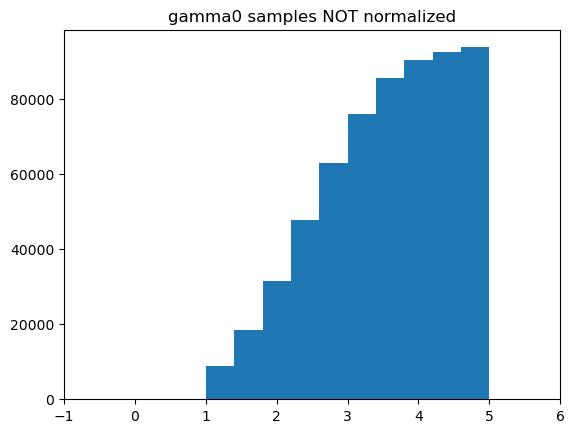

1.0000200713283807
4.999995795447318


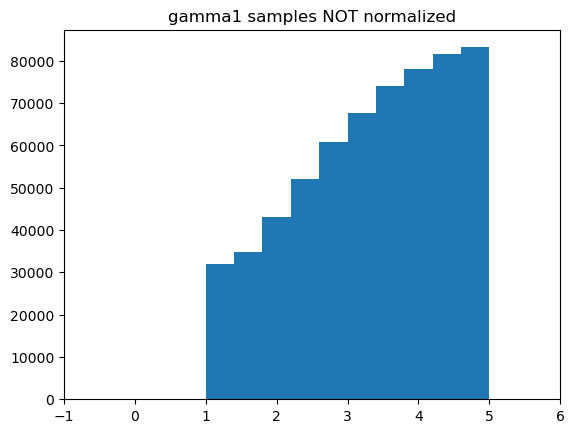

1.0000048761133824
4.109757007852588


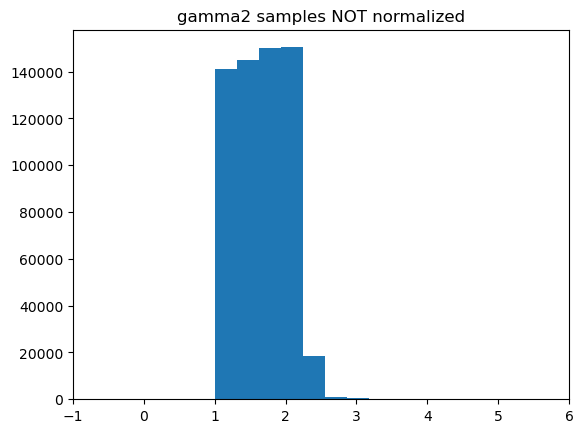

33.00000999097819
36.998293740895924


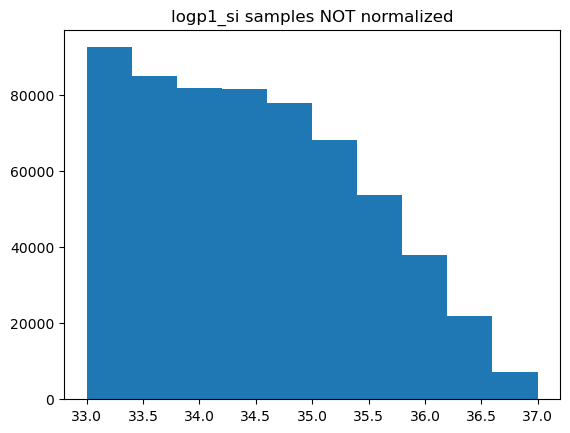

33.01290019655025
36.999999141915985


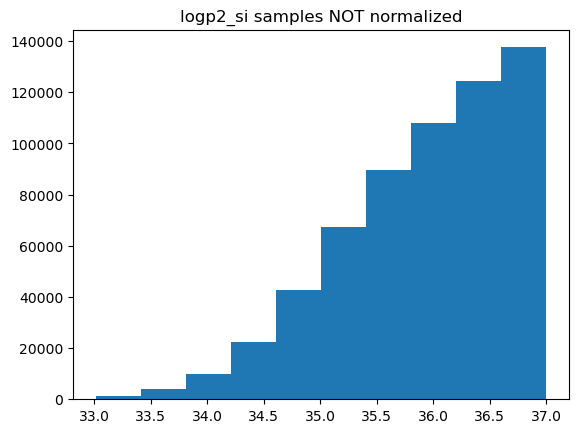

In [34]:
plt.hist(gamma0_real[0:607078])
plt.title("gamma0 samples NOT normalized")
print(np.min(gamma0_real))
print(np.max(gamma0_real))
plt.xlim(-1, 6)
plt.show()

plt.hist(gamma1_real[0:607078])
plt.title("gamma1 samples NOT normalized")
print(np.min(gamma1_real))
print(np.max(gamma1_real))
plt.xlim(-1, 6)
plt.show()

plt.hist(gamma2_real[0:607078])
plt.title("gamma2 samples NOT normalized")
print(np.min(gamma2_real))
print(np.max(gamma2_real))
plt.xlim(-1, 6)
plt.show()

plt.hist(logp1_cgs[0:607078])
plt.title("logp1_si samples NOT normalized")
print(np.min(logp1_cgs))
print(np.max(logp1_cgs))
#plt.xlim(-.4, 1)
plt.show()

plt.hist(logp2_cgs[0:607078])
plt.title("logp2_si samples NOT normalized")
print(np.min(logp2_cgs))
print(np.max(logp2_cgs))
#plt.xlim(-.4, 1)
plt.show()

normalized outputs

3.7796567830483685e-05
0.9999995078725408


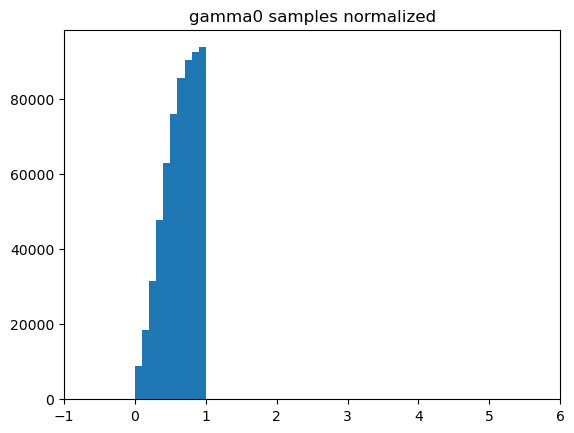

5.017832095166597e-06
0.9999989488618295


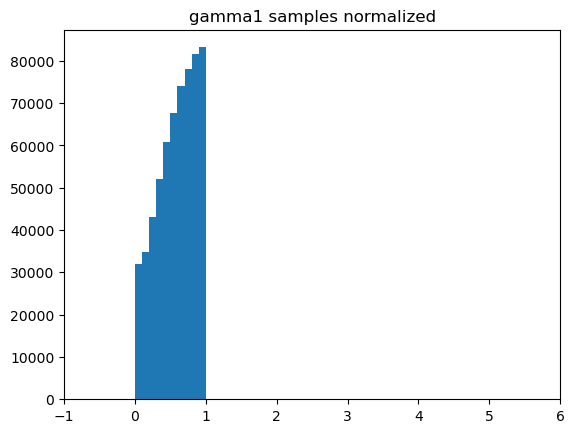

1.2190283456003925e-06
0.777439251963147


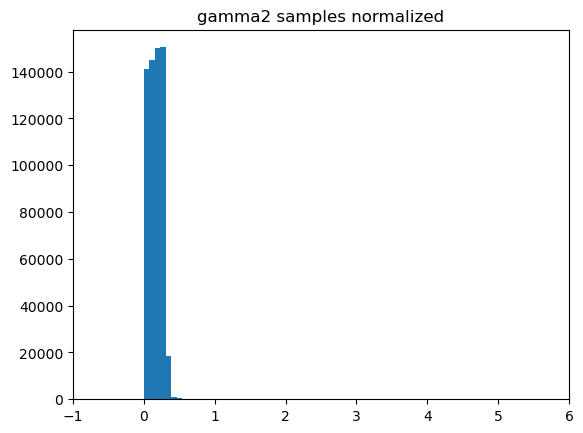

2.4977445480800498e-06
0.9995734352239811


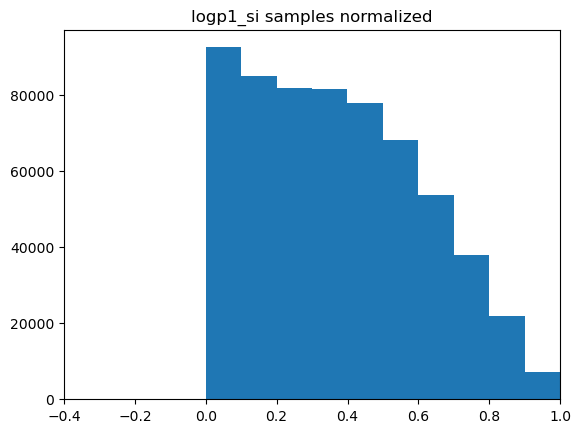

0.0032250491375620527
0.9999997854789964


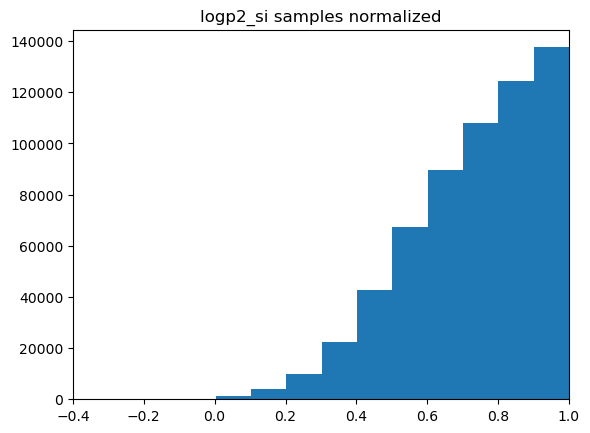

In [35]:
plt.hist(sd_gamma0[0:607078])
plt.title("gamma0 samples normalized")
print(np.min(sd_gamma0))
print(np.max(sd_gamma0))
plt.xlim(-1, 6)
plt.show()

plt.hist(sd_gamma1[0:607078])
plt.title("gamma1 samples normalized")
print(np.min(sd_gamma1))
print(np.max(sd_gamma1))
plt.xlim(-1, 6)
plt.show()

plt.hist(sd_gamma2[0:607078])
plt.title("gamma2 samples normalized")
print(np.min(sd_gamma2))
print(np.max(sd_gamma2))
plt.xlim(-1, 6)
plt.show()

plt.hist(logp1_si[0:607078])
plt.title("logp1_si samples normalized")
print(np.min(logp1_si))
print(np.max(logp1_si))
plt.xlim(-.4, 1)
plt.show()

plt.hist(logp2_si[0:607078])
plt.title("logp2_si samples normalized")
print(np.min(logp2_si))
print(np.max(logp2_si))
plt.xlim(-.4, 1)
plt.show()

In [11]:
#create an empty array 8 x length(m1_dat]) for vals
array_size =  np.array([[0] * 9 ] * len(sd_gamma0))
array_size = array_size.astype('float64')
combined_array = np.zeros_like(array_size)
print(combined_array.dtype)
print(combined_array.shape)

float64
(607078, 9)


In [12]:
#reformat data files into this new array
for i in range(0,len(m1_dat)-1):
    combined_array[i][0] = m1_dat[i]
    combined_array[i][1] = m2_dat[i]
    combined_array[i][2] = l1_dat[i]
    combined_array[i][3] = l2_dat[i]
    combined_array[i][4] = sd_gamma0[i]
    combined_array[i][5] = sd_gamma1[i]
    combined_array[i][6] = sd_gamma2[i]
    combined_array[i][7] = logp1_si[i]
    combined_array[i][8] = logp2_si[i]
    

In [13]:
data = pd.DataFrame(combined_array)
data.columns = ['m1','m2', 'l1', 'l2','gamma0', 'gamma1', 'gamma2', 'logp1_si', 'logp2_si']
print(data)

              m1        m2            l1            l2    gamma0    gamma1  \
0       1.704363  0.940013     48.538860     48.538860  0.437453  0.790931   
1       0.674195  0.488352  42688.433302  42688.433302  0.648856  0.745487   
2       1.944506  1.625537    167.805410    167.805410  0.630087  0.988135   
3       0.582582  0.362044  48488.884176  48488.884176  0.479282  0.037464   
4       2.684166  2.462512     51.173074     51.173074  0.813159  0.580368   
...          ...       ...           ...           ...       ...       ...   
607073  1.013666  0.796982    824.208582    824.208582  0.123919  0.742199   
607074  2.164040  2.108632    317.060866    317.060866  0.977682  0.877431   
607075  1.076021  0.455083   9037.102442   9037.102442  0.956124  0.782363   
607076  2.920096  1.229460     30.600294     30.600294  0.842959  0.731056   
607077  0.000000  0.000000      0.000000      0.000000  0.000000  0.000000   

          gamma2  logp1_si  logp2_si  
0       0.034513  0.5913

In [14]:
int(len(m2_real)*.8)

485662

In [15]:
# 541 total samples: 80% = 432, 20% = 108.2
# for train and test ONLY:
# we want the first 432 samples to = train
# we want the last 109 samples to = test
# split row-wise, not collumn-wise

# splitting dataframe by row index
train = data.iloc[:int(len(m2_real)*.8),:]
test = data.iloc[int(len(m2_real)*.8):,:]
print("Shape of new dataframes - {} , {}".format(train.shape, test.shape))

train_stats = train.describe()

train_stats.pop('gamma0')
train_stats.pop('gamma1')
train_stats.pop('gamma2')
train_stats.pop('logp1_si')
train_stats.pop('logp2_si')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)


Shape of new dataframes - (485662, 9) , (121416, 9)


In [16]:
#split data into train and test

data = data.sample(frac=1).reset_index(drop=True)

train, test = train_test_split(data, test_size=0.2)

print(train)

train_stats = train.describe()

#get gamma as the outputs and format them as np arrays.

train_stats.pop('gamma0')
train_stats.pop('gamma1')
train_stats.pop('gamma2')
train_stats.pop('logp1_si')
train_stats.pop('logp2_si')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

              m1        m2            l1            l2    gamma0    gamma1  \
162413  1.806268  1.526073     67.069747     67.069747  0.483683  0.383051   
344527  0.923965  0.662175  16859.483974  16859.483974  0.912242  0.982365   
560909  1.213023  0.445655   1870.139333   1870.139333  0.569289  0.436321   
193330  0.985254  0.436569   4429.222985   4429.222985  0.524396  0.491150   
200879  1.618819  0.558073    808.638703    808.638703  0.513243  0.858227   
...          ...       ...           ...           ...       ...       ...   
35859   1.017555  0.713971    252.527970    252.527970  0.187117  0.830743   
205374  0.845033  0.482709  25500.041726  25500.041726  0.938986  0.946292   
218635  0.691592  0.416616   1289.930118   1289.930118  0.210382  0.421937   
65331   2.076520  0.652549     38.704195     38.704195  0.529398  0.935513   
388021  0.783335  0.549544  33902.476570  33902.476570  0.904134  0.373566   

          gamma2  logp1_si  logp2_si  
162413  0.268333  0.7413

In [17]:
norm_train_X = train
norm_test_X = test

In [18]:
input_layer = Input(shape=(len(train .columns),))

layeract = 'tanh'
outputact = 'sigmoid'

first_dense = Dense(units='128', activation=layeract)(input_layer)
second_dense = Dense(units='128', activation=layeract)(first_dense)
third_dense = Dense(units='128', activation=layeract)(second_dense)
fourth_dense = Dense(units='128', activation=layeract)(third_dense)
fifth_dense = Dense(units='128', activation=layeract)(fourth_dense)
sixth_dense = Dense(units='128', activation=layeract)(fifth_dense)
seventh_dense = Dense(units='128', activation=layeract)(sixth_dense)
eight_dense = Dense(units='128', activation=layeract)(seventh_dense)
ninth_dense = Dense(units='128', activation=layeract)(eight_dense)
    
tenth_dense = Dense(units='128', activation=layeract)(ninth_dense)
eleventh_dense = Dense(units='128', activation=layeract)(tenth_dense)
twelth_dense = Dense(units='128', activation=layeract)(eleventh_dense)
thirteenth_dense = Dense(units='128', activation=layeract)(twelth_dense)
fourteenth_dense = Dense(units='128', activation=layeract)(thirteenth_dense)
fifteenth_dense = Dense(units='128', activation=layeract)(fourteenth_dense)
sixteenth_dense = Dense(units='128', activation=layeract)(fifteenth_dense)
seventeenth_dense = Dense(units='128', activation=layeract)(sixteenth_dense)
eighteenth_dense = Dense(units='128', activation=layeract)(seventeenth_dense)
nineteenth_dense = Dense(units='128', activation=layeract)(eighteenth_dense)
    
twentieth_dense = Dense(units='128', activation=layeract)(nineteenth_dense)
tf_dense = Dense(units='128', activation=layeract)(twentieth_dense)
ts_dense = Dense(units='128', activation=layeract)(tf_dense)
tt_dense = Dense(units='128', activation=layeract)(ts_dense)
tfo_dense = Dense(units='128', activation=layeract)(tt_dense)
tfi_dense = Dense(units='128', activation=layeract)(tfo_dense)
ts_dense = Dense(units='128', activation=layeract)(tfi_dense)
tse_dense = Dense(units='128', activation=layeract)(ts_dense)
te_dense = Dense(units='128', activation=layeract)(tse_dense)
tn_dense = Dense(units='128', activation=layeract)(te_dense)


gamma0_output = Dense(units='1', activation=outputact, name='gamma0_output')(tn_dense)
thf_dense = Dense(units='64', activation=layeract)(tn_dense)

ths_dense = Dense(units='128', activation=layeract)(thf_dense)
tht_dense = Dense(units='128', activation=layeract)(ths_dense)
thfo_dense = Dense(units='128', activation=layeract)(tht_dense)
thfi_dense = Dense(units='128', activation=layeract)(thfo_dense)
ths_dense = Dense(units='128', activation=layeract)(thfi_dense)
thse_dense = Dense(units='128', activation=layeract)(ths_dense)
the_dense = Dense(units='128', activation=layeract)(thse_dense)
thn_dense = Dense(units='128', activation=layeract)(the_dense)

gamma1_output = Dense(units='1', activation=outputact, name='gamma1_output')(thn_dense)
fo_dense = Dense(units='32',activation=layeract)(thn_dense)

fof_dense = Dense(units='128', activation=layeract)(fo_dense)
fos_dense = Dense(units='128', activation=layeract)(fof_dense)
fot_dense = Dense(units='128', activation=layeract)(fos_dense)
fofo_dense = Dense(units='128', activation=layeract)(fot_dense)
fofi_dense = Dense(units='128', activation=layeract)(fofo_dense)

gamma2_output = Dense(units='1', activation=outputact, name='gamma2_output')(fofi_dense)
fos_dense = Dense(units='16',activation=layeract)(fofi_dense)

fose_dense = Dense(units='128', activation=layeract)(fos_dense)
foe_dense = Dense(units='128', activation=layeract)(fose_dense)
fon_dense = Dense(units='128', activation=layeract)(foe_dense)
fif_dense = Dense(units='128', activation=layeract)(fon_dense)

logp1_si_output = Dense(units='1', activation=outputact, name='logp1_si_output')(fon_dense)

fiff_dense = Dense(units='128', activation=layeract)(fon_dense)
fifs_dense = Dense(units='128', activation=layeract)(fiff_dense)
fift_dense = Dense(units='128', activation=layeract)(fifs_dense)
fiff_dense = Dense(units='128', activation=layeract)(fift_dense)
fiffi_dense = Dense(units='128', activation=layeract)(fiff_dense)
fifs_dense = Dense(units='128', activation=layeract)(fiffi_dense)

logp2_si_output = Dense(units='1', activation=outputact, name='logp2_si_output')(fifs_dense)


model = Model(inputs=input_layer, outputs=[gamma0_output, gamma1_output, gamma2_output, logp1_si_output, logp2_si_output])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 4)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 128)                  640       ['input_1[0][0]']             
                                                                                                  
 dense_1 (Dense)             (None, 128)                  16512     ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 128)                  16512     ['dense_1[0][0]']             
                                                                                              

 dense_39 (Dense)            (None, 128)                  4224      ['dense_38[0][0]']            
                                                                                                  
 dense_40 (Dense)            (None, 128)                  16512     ['dense_39[0][0]']            
                                                                                                  
 dense_41 (Dense)            (None, 128)                  16512     ['dense_40[0][0]']            
                                                                                                  
 dense_42 (Dense)            (None, 128)                  16512     ['dense_41[0][0]']            
                                                                                                  
 dense_43 (Dense)            (None, 128)                  16512     ['dense_42[0][0]']            
                                                                                                  
 dense_44 

In [19]:
#plot_model(model, to_file='DynamicPolytropeMLA.png', show_shapes=True, show_layer_names=True)

In [20]:
#specify the optimizer as stochastic gradient descent and will mention the learning rate as 0.001
#compile the model with loss functions for both outputs
from keras import metrics

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss={'gamma0_output': 'mse', 'gamma1_output': 'mse', 'gamma2_output': 'mse', 'logp1_si_output': 'mse', 'logp2_si_output': 'mse'},
              metrics={
                       'gamma0_output': tf.keras.metrics.MeanSquaredError() ,
                       'gamma1_output': tf.keras.metrics.MeanSquaredError(),
                       'gamma2_output': tf.keras.metrics.MeanSquaredError() ,
                       'logp1_si_output': tf.keras.metrics.MeanSquaredError(),
                       'logp2_si_output': tf.keras.metrics.MeanSquaredError()
                      })

endmetric = "mean_squared_error"

In [ ]:
#train the model for a number of epochs

numepochs = 500
    
history = model.fit(norm_train_X.to_numpy(), train_Y,
                    epochs=numepochs, batch_size=10, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001,patience=200,mode='auto')])



Epoch 1/500


2023-11-14 12:33:18.754726: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-14 12:33:18.843946: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2b5bcbb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-14 12:33:18.843962: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-11-14 12:33:18.843966: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
2023-11-14 12:33:18.847718: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-14 12:33:18.983461: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-14 12:33:19.068406: I

38853/38853 [==============================] - 345s 9ms/step - loss: 0.2140 - gamma0_output_loss: 0.0410 - gamma1_output_loss: 0.0720 - gamma2_output_loss: 0.0089 - logp1_si_output_loss: 0.0567 - logp2_si_output_loss: 0.0355 - gamma0_output_mean_squared_error: 0.0410 - gamma1_output_mean_squared_error: 0.0720 - gamma2_output_mean_squared_error: 0.0089 - logp1_si_output_mean_squared_error: 0.0567 - logp2_si_output_mean_squared_error: 0.0355 - val_loss: 0.2037 - val_gamma0_output_loss: 0.0326 - val_gamma1_output_loss: 0.0716 - val_gamma2_output_loss: 0.0088 - val_logp1_si_output_loss: 0.0556 - val_logp2_si_output_loss: 0.0351 - val_gamma0_output_mean_squared_error: 0.0326 - val_gamma1_output_mean_squared_error: 0.0716 - val_gamma2_output_mean_squared_error: 0.0088 - val_logp1_si_output_mean_squared_error: 0.0556 - val_logp2_si_output_mean_squared_error: 0.0351
Epoch 2/500
38853/38853 [==============================] - 336s 9ms/step - loss: 0.2103 - gamma0_output_loss: 0.0381 - gamma1_out

In [ ]:
loss, gamma0_loss, gamma0_accuracy, gamma1_loss, gamma1_accuracy, gamma2_loss, gamma2_accuracy, logp1_si_loss, logp1_si_accuracy, logp2_si_loss, logp2_si_accuracy = model.evaluate(x=norm_test_X.to_numpy(), y=test_Y)


In [ ]:
new_predictions = model.predict(norm_train_X.to_numpy())
predictions = unnorm(new_predictions)
#predictions = minmaxunnorm(new_predictions)

In [24]:
len(predictions)

432

In [25]:
print(predictions)

[[ 3.9007158  3.5227604  1.6230586 34.77008   36.178127 ]
 [ 3.8844967  3.5085201  1.6085553 34.77215   36.184612 ]
 [ 3.8946722  3.5058427  1.6145586 34.77272   36.18724  ]
 ...
 [ 3.9411433  3.4958239  1.6523144 34.766426  36.189754 ]
 [ 3.8420084  3.175405   1.658503  34.63347   36.04672  ]
 [ 3.8523288  3.357879   1.6486464 34.697613  36.085323 ]]


normalized outputs histogram

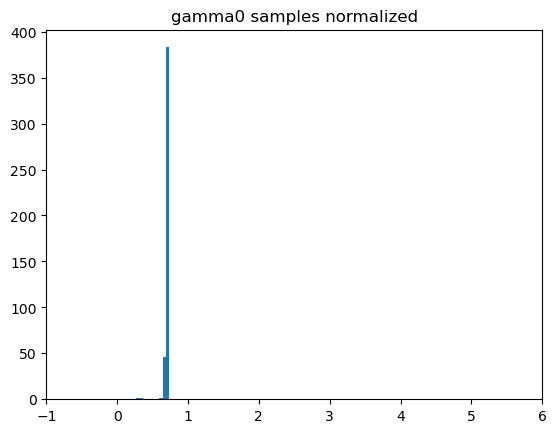

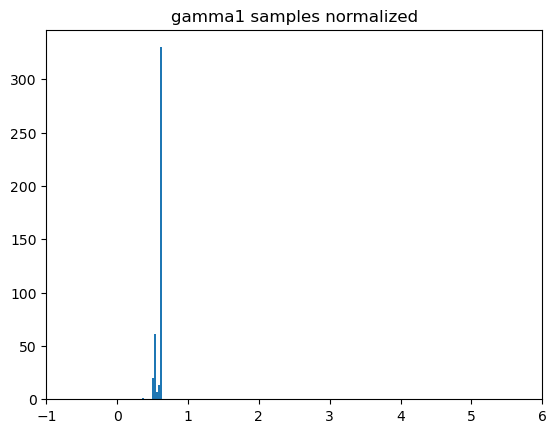

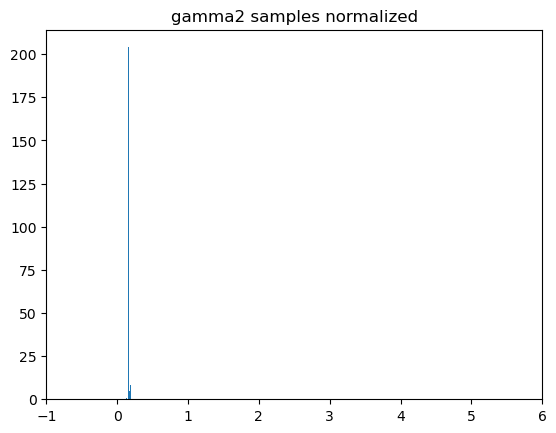

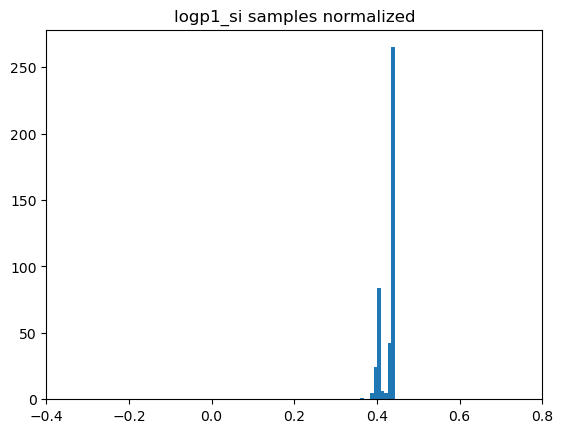

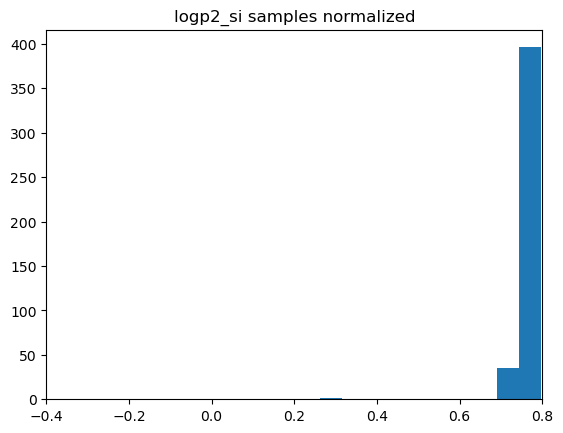

In [26]:
plt.hist(new_predictions[0])
plt.title("gamma0 samples normalized")
#print(np.min(new_predictions[0]))
#print(np.max(new_predictions[0]))
plt.xlim(-1, 6)
plt.show()

plt.hist(new_predictions[1])
plt.title("gamma1 samples normalized")
#print(np.min(new_predictions[1]))
#print(np.max(new_predictions[1]))
plt.xlim(-1, 6)
plt.show()

plt.hist(new_predictions[2])
plt.title("gamma2 samples normalized")
#print(np.min(new_predictions[2]))
#print(np.max(new_predictions[2]))
plt.xlim(-1, 6)
plt.show()

plt.hist(new_predictions[3])
plt.title("logp1_si samples normalized")
#print(np.min(new_predictions[3]))
#print(np.max(new_predictions[3]))
plt.xlim(-.4, .8)
plt.show()

plt.hist(new_predictions[4])
plt.title("logp2_si samples normalized")
#print(np.min(new_predictions[4]))
#print(np.max(new_predictions[4]))
plt.xlim(-.4, .8)
plt.show()

un-normalized outputs histogram

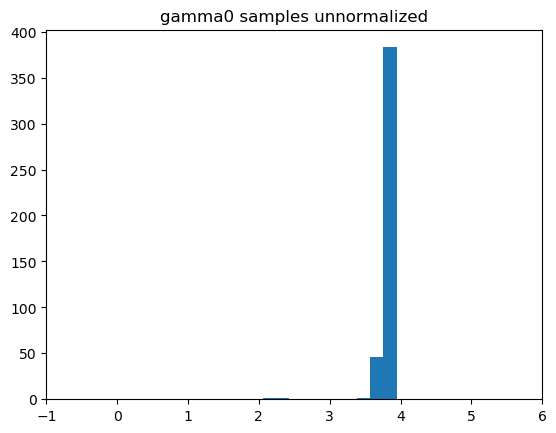

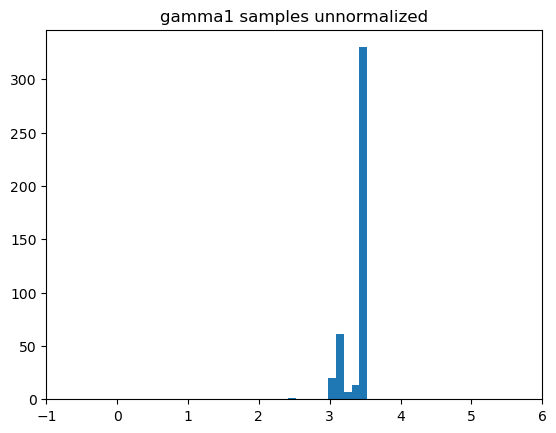

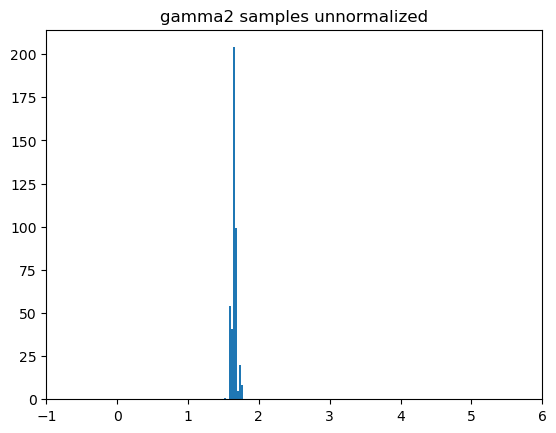

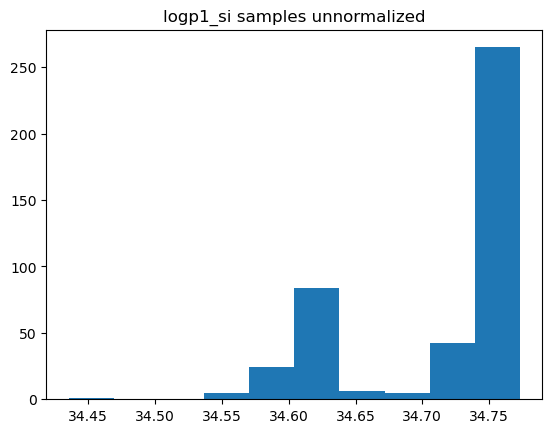

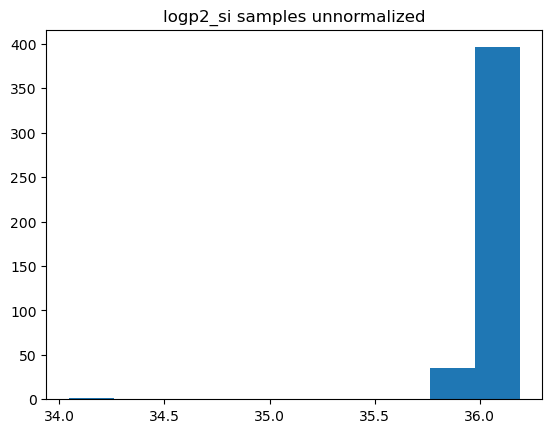

In [27]:
normgam0ar = []
for i in range (485662):
    normgam0ar.append(predictions[i][0])
plt.hist(normgam0ar)
plt.title("gamma0 samples unnormalized")
plt.xlim(-1, 6)
plt.show()


normgam1ar = []
for i in range (485662):
    normgam1ar.append(predictions[i][1])
plt.hist(normgam1ar)
plt.title("gamma1 samples unnormalized")
plt.xlim(-1, 6)
plt.show()


normgam2ar = []
for i in range (485662):
    normgam2ar.append(predictions[i][2])
plt.hist(normgam2ar)
plt.title("gamma2 samples unnormalized")
#print(np.min(new_predictions[2]))
#print(np.max(new_predictions[2]))
plt.xlim(-1, 6)
plt.show()


normlogp1ar = []
for i in range (485662):
    normlogp1ar.append(predictions[i][3])
plt.hist(normlogp1ar)
plt.title("logp1_si samples unnormalized")
#print(np.min(new_predictions[3]))
#print(np.max(new_predictions[3]))
#plt.xlim(-.4, .8)
plt.show()


normlogp2ar = []
for i in range (485662):
    normlogp2ar.append(predictions[i][4])
plt.hist(normlogp2ar)
plt.title("logp2_si samples unnormalized")
#print(np.min(new_predictions[4]))
#print(np.max(new_predictions[4]))
#plt.xlim(-.4, .8)
plt.show()

# Plot one EOS

In [28]:

# log(p1) & p2 ∈ [33, 37], in cgs
# [32, 36] in si
# Γ0, Γ1, Γ2 ∈ [1.0, 5.0]

fgam0 = float(predictions[0][0])
print(fgam0)
fgam1 = float(predictions[0][1])
print(fgam1)
fgam2 = float(predictions[0][2])
print(fgam2)
flogp1 = float(predictions[0][3])
print(flogp1)
flogp2 = float(predictions[0][4]) 
print(flogp2)

3.9007158279418945
3.5227603912353516
1.623058557510376
34.77008056640625
36.17812728881836


In [29]:
oneEOS = lal.SimNeutronStarEOS3PieceDynamicPolytrope(fgam0, flogp1, fgam1, flogp2, fgam2)

In [30]:
act_hmin = 0.01
act_hmax = lal.SimNeutronStarEOSMaxPseudoEnthalpy(oneEOS)

act_loghmin = np.log10(act_hmin)
act_loghmax = np.log10(act_hmax)

act_h_array = np.linspace(act_loghmin,act_loghmax,1000)

act_density = []
act_pressure = []

for h in act_h_array:
    act_density.append(lal.SimNeutronStarEOSRestMassDensityOfPseudoEnthalpy(10**h,oneEOS))
    act_pressure.append(lal.SimNeutronStarEOSPressureOfPseudoEnthalpy(10**h,oneEOS))
    
    
act_density = np.array(act_density)
act_pressure = np.array(act_pressure)

#cgs units
act_density_cgs = act_density * 1e-3
act_pressure_cgs = act_pressure * 10

act_logdensity = np.log10(act_density_cgs)
act_logpressure = np.log10(act_pressure_cgs)

Text(0, 0.5, 'pressure')

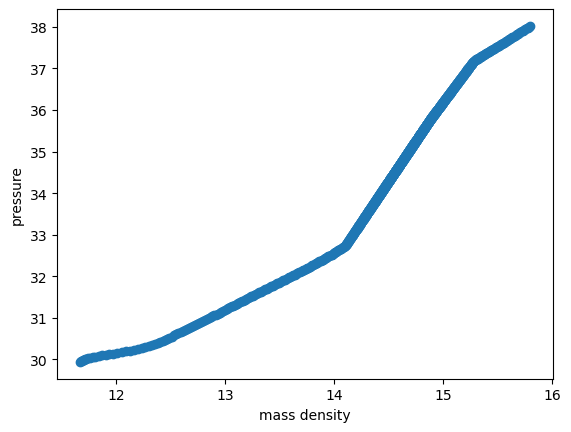

In [31]:
plt.plot(act_logdensity,act_logpressure,marker = 'o')
plt.xlabel("mass density")
plt.ylabel("pressure")
#plt.xlim([14,15.4])
#plt.ylim([32,37])

# EOS


In [32]:
#length = len(predictions)
length = 485662

Progress : 0 / 432, 0.00%
Progress : 30 / 432, 6.94%
Progress : 60 / 432, 13.89%
Progress : 90 / 432, 20.83%
Progress : 120 / 432, 27.78%
Progress : 150 / 432, 34.72%
Progress : 180 / 432, 41.67%
Progress : 210 / 432, 48.61%
Progress : 240 / 432, 55.56%
Progress : 270 / 432, 62.50%
Progress : 300 / 432, 69.44%
Progress : 330 / 432, 76.39%
Progress : 360 / 432, 83.33%
Progress : 390 / 432, 90.28%
Progress : 420 / 432, 97.22%


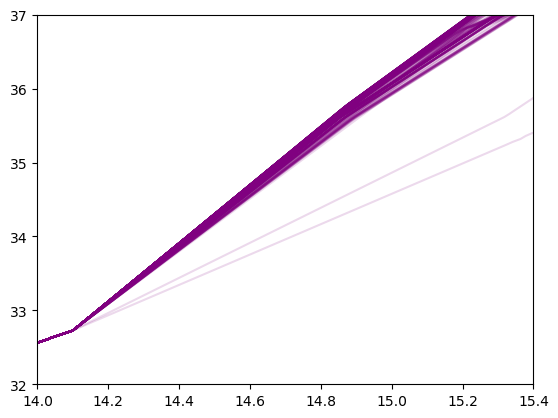

0


In [33]:
hlow_0 = 0.022460530117115313
hlow_1 = 0.024210313916473953
hlow = np.linspace(hlow_0,hlow_1,10,endpoint=False)
bad = 0
for i in range(length):
    try: 
        g0 = float(predictions[i][0])
        g1 = float(predictions[i][1])
        g2 = float(predictions[i][2])
        p1 = float(predictions[i][3])
        p2 = float(predictions[i][4])

        if i%30==0:
            print('Progress : %d / %d, %0.2f%%'%(i,length,float(i/length*100)))
        pdat = []
        rdat = []
        #eos = lal.SimNeutronStarEOS3PieceDynamicPolytrope(g0[i],p1[i]-1,g1[i],p2[i]-1,g2[i])
        eos = lal.SimNeutronStarEOS3PieceDynamicPolytrope(g0,p1,g1,p2,g2)
        hmax = lal.SimNeutronStarEOSMaxPseudoEnthalpy(eos)
        hhigh = 10**np.linspace(np.log10(hlow_1),np.log10(hmax-.0001),100)
        hdat = np.concatenate([hlow,hhigh])
        for h in hdat:
            pdat.append(lal.SimNeutronStarEOSPressureOfPseudoEnthalpy(h,eos)*10)
            rdat.append(lal.SimNeutronStarEOSRestMassDensityOfPseudoEnthalpy(h,eos)*.001)
        #plt.plot(np.log10(rdat),np.log10(pdat),'o',alpha=0.15)
        plt.plot(np.log10(rdat),np.log10(pdat),color='purple',alpha=0.15)
        
    except:
        print("failed")
        bad += 1
        
plt.xlim([14,15.4])
plt.ylim([32,37])
plt.show()
print(bad)

# Actual Values EOS

In [50]:
gamma0 = np.loadtxt("eos_polytrope_gamma_0.dat.txt", dtype=float)
gamma1 = np.loadtxt("eos_polytrope_gamma_1.dat.txt", dtype=float)
gamma2 = np.loadtxt("eos_polytrope_gamma_2.dat.txt", dtype=float)
l1 = np.loadtxt('lambda_1.dat.txt', dtype=float)
l2 = np.loadtxt('lambda_2.dat.txt', dtype=float)
logp1_cgs = np.loadtxt("eos_polytrope_log_pressure_1.dat.txt", dtype=float)
logp2_cgs = np.loadtxt("eos_polytrope_log_pressure_2.dat.txt", dtype=float)
m1 = np.loadtxt("mass_1_source.dat.txt", dtype=float)
m2 = np.loadtxt("mass_2_source.dat.txt", dtype=float)

logp1_s = logp1_cgs - 1
logp2_s = logp2_cgs - 1

#length = len(gamma0)
length = 485662

Progress : 0 / 500, 0.00%
Progress : 10 / 500, 2.00%
Progress : 20 / 500, 4.00%
Progress : 30 / 500, 6.00%
Progress : 40 / 500, 8.00%
Progress : 50 / 500, 10.00%
Progress : 60 / 500, 12.00%
Progress : 70 / 500, 14.00%
Progress : 80 / 500, 16.00%
Progress : 90 / 500, 18.00%
Progress : 100 / 500, 20.00%
Progress : 110 / 500, 22.00%
Progress : 120 / 500, 24.00%
Progress : 130 / 500, 26.00%
Progress : 140 / 500, 28.00%
Progress : 150 / 500, 30.00%
Progress : 160 / 500, 32.00%
Progress : 170 / 500, 34.00%
Progress : 180 / 500, 36.00%
Progress : 190 / 500, 38.00%
Progress : 200 / 500, 40.00%
Progress : 210 / 500, 42.00%
Progress : 220 / 500, 44.00%
Progress : 230 / 500, 46.00%
Progress : 240 / 500, 48.00%
Progress : 250 / 500, 50.00%
Progress : 260 / 500, 52.00%
Progress : 270 / 500, 54.00%
Progress : 280 / 500, 56.00%
Progress : 290 / 500, 58.00%
Progress : 300 / 500, 60.00%
Progress : 310 / 500, 62.00%
Progress : 320 / 500, 64.00%
Progress : 330 / 500, 66.00%
Progress : 340 / 500, 68.00%
P

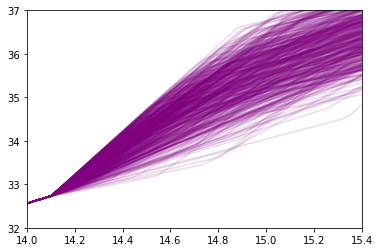

In [51]:
hlow_0 = 0.022460530117115313
hlow_1 = 0.024210313916473953
hlow = np.linspace(hlow_0,hlow_1,10,endpoint=False)
for i in range(length):

    g0 = float(gamma0[i])
    g1 = float(gamma1[i])
    g2 = float(gamma2[i])
    p1 = float(logp1_s[i])
    p2 = float(logp2_s[i])
    
    if i%10==0:
        print('Progress : %d / %d, %0.2f%%'%(i,length,float(i/length*100)))
    pdat = []
    rdat = []
    #eos = lal.SimNeutronStarEOS3PieceDynamicPolytrope(g0[i],p1[i]-1,g1[i],p2[i]-1,g2[i])
    eos = lal.SimNeutronStarEOS3PieceDynamicPolytrope(g0,p1,g1,p2,g2)
    hmax = lal.SimNeutronStarEOSMaxPseudoEnthalpy(eos)
    hhigh = 10**np.linspace(np.log10(hlow_1),np.log10(hmax-.0001),100)
    hdat = np.concatenate([hlow,hhigh])
    for h in hdat:
        pdat.append(lal.SimNeutronStarEOSPressureOfPseudoEnthalpy(h,eos)*10)
        rdat.append(lal.SimNeutronStarEOSRestMassDensityOfPseudoEnthalpy(h,eos)*.001)
    #plt.plot(np.log10(rdat),np.log10(pdat),'o',alpha=0.15)
    plt.plot(np.log10(rdat),np.log10(pdat),color='purple',alpha=0.15)
plt.xlim([14,15.4])
plt.ylim([32,37])
plt.show()

# Loss

In [52]:
history.history.keys() 

dict_keys(['loss', 'gamma0_output_loss', 'gamma1_output_loss', 'gamma2_output_loss', 'logp1_si_output_loss', 'logp2_si_output_loss', 'gamma0_output_mean_squared_error', 'gamma1_output_mean_squared_error', 'gamma2_output_mean_squared_error', 'logp1_si_output_mean_squared_error', 'logp2_si_output_mean_squared_error', 'val_loss', 'val_gamma0_output_loss', 'val_gamma1_output_loss', 'val_gamma2_output_loss', 'val_logp1_si_output_loss', 'val_logp2_si_output_loss', 'val_gamma0_output_mean_squared_error', 'val_gamma1_output_mean_squared_error', 'val_gamma2_output_mean_squared_error', 'val_logp1_si_output_mean_squared_error', 'val_logp2_si_output_mean_squared_error'])

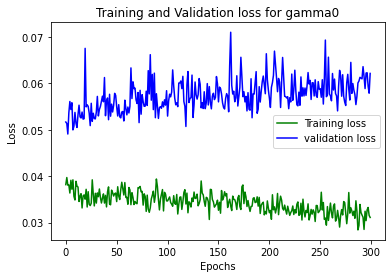

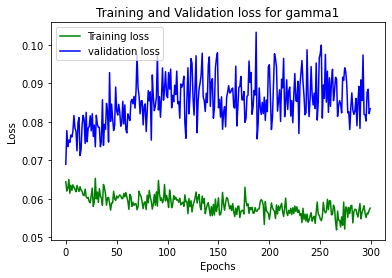

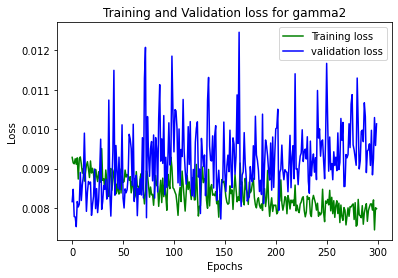

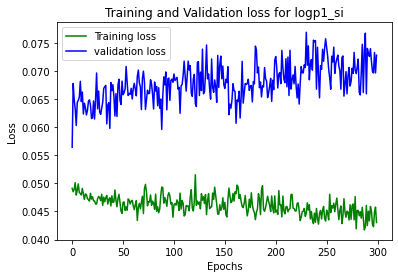

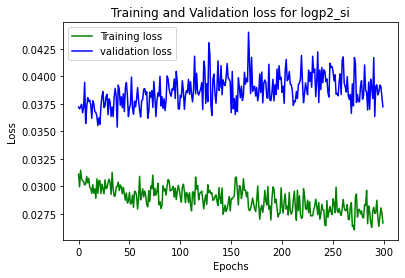

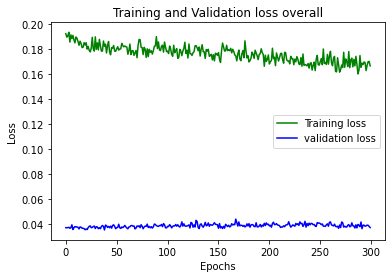

In [53]:
#loss for gamma0 values
loss_train = history.history['gamma0_output_loss']
loss_val = history.history['val_gamma0_output_loss']
epochs = range(0,numepochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for gamma0')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#loss for gamma1 values
loss_train = history.history['gamma1_output_loss']
loss_val = history.history['val_gamma1_output_loss']
epochs = range(0,numepochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for gamma1')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#loss for gamma2 values
loss_train = history.history['gamma2_output_loss']
loss_val = history.history['val_gamma2_output_loss']
epochs = range(0,numepochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for gamma2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#loss for logp1_si values
loss_train = history.history['logp1_si_output_loss']
loss_val = history.history['val_logp1_si_output_loss']
epochs = range(0,numepochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for logp1_si')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


#loss for logp2_si values
loss_train = history.history['logp2_si_output_loss']
loss_val = history.history['val_logp2_si_output_loss']
epochs = range(0,numepochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss for logp2_si')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


#overall loss
loss_train = history.history['loss']
loss_val = history.history['val_logp2_si_output_loss']
epochs = range(0,numepochs)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss overall')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()